In [1]:
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle
from xgboost import XGBClassifier

In [2]:
def draw_y_lines(boundaries: list, ax: Axes):
    for boundary in boundaries:
        ax.axhline(y=boundary, linestyle='--', color='0.6')


def draw_x_lines(boundaries: list, ax: Axes):
    for boundary in boundaries:
        ax.axvline(x=boundary, linestyle='--', color='0.6')

def plot_area_matrix(
    clean_data_df: pd.DataFrame,
    x_feature: str,
    y_feature: str,
    count_feature: str,
    x_boundaries: list,
    y_boundaries: list,
    ax: Axes,
):
    draw_x_lines(boundaries=x_boundaries, ax=ax)
    draw_y_lines(boundaries=y_boundaries, ax=ax)
    sns.scatterplot(data=clean_data_df,
                    x=x_feature,
                    y=y_feature,
                    ax=ax,
                    hue=count_feature,
                    linewidth=1,
                    edgecolor='black',
                    alpha=0.7,
                    style=count_feature)

    for i in range(len(x_boundaries) - 1):
        x_left_bound = x_boundaries[i]
        x_right_bound = x_boundaries[i+1]
        for j in range(len(y_boundaries) - 1):
            y_left_bound = y_boundaries[j]
            y_right_bound = y_boundaries[j+1]
            # filtering & counting
            sub_data_df = clean_data_df[(clean_data_df[y_feature].between(y_left_bound, y_right_bound)) &
                                        (clean_data_df[x_feature].between(x_left_bound, x_right_bound))]
            total_count = sub_data_df.shape[0]
            if total_count < 1:
                continue
            count_map = sub_data_df[count_feature].value_counts()

            if total_count > 0:
                no_count = count_map[0] if 0 in count_map.index else 0
                yes_count = count_map[1] if 1 in count_map.index else 0

                o_y = y_left_bound
                o_x = x_left_bound
                rect_height = y_right_bound - o_y
                rect_width = x_right_bound - o_x

                yes_ratio = yes_count / total_count

                area_color = list(mpl.colormaps['coolwarm'](yes_ratio))
                area_color[3] = 0.8

                rect = Rectangle(
                    (o_x, o_y), rect_width, rect_height, facecolor=area_color
                )
                # label_str = f"{yes_ratio:.2f}\n0: {no_count}\n1: {yes_count}\nTotal: {total_count}"
                label_str = f"{yes_ratio:.2f}\nTotal: {total_count}"
                ax.add_patch(rect)
                ax.text(
                    x=o_x + rect_width / 2,
                    y=o_y + rect_height / 2,
                    s=label_str,
                    color='white',
                    fontsize=10,
                    ha='center',
                    va='center',
                    weight='bold',
                    path_effects=[path_effects.withStroke(linewidth=2, foreground="black")]
                )

In [3]:
data_df=pd.read_csv("data/diabetes.csv")
clean_data_df = data_df[
    (data_df['Glucose'] != 0) &
    (data_df['BloodPressure'] != 0) &
    (data_df['SkinThickness'] != 0) &
    (data_df['Insulin'] != 0) &
    (data_df['BMI'] != 0)
]

clean_data_df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


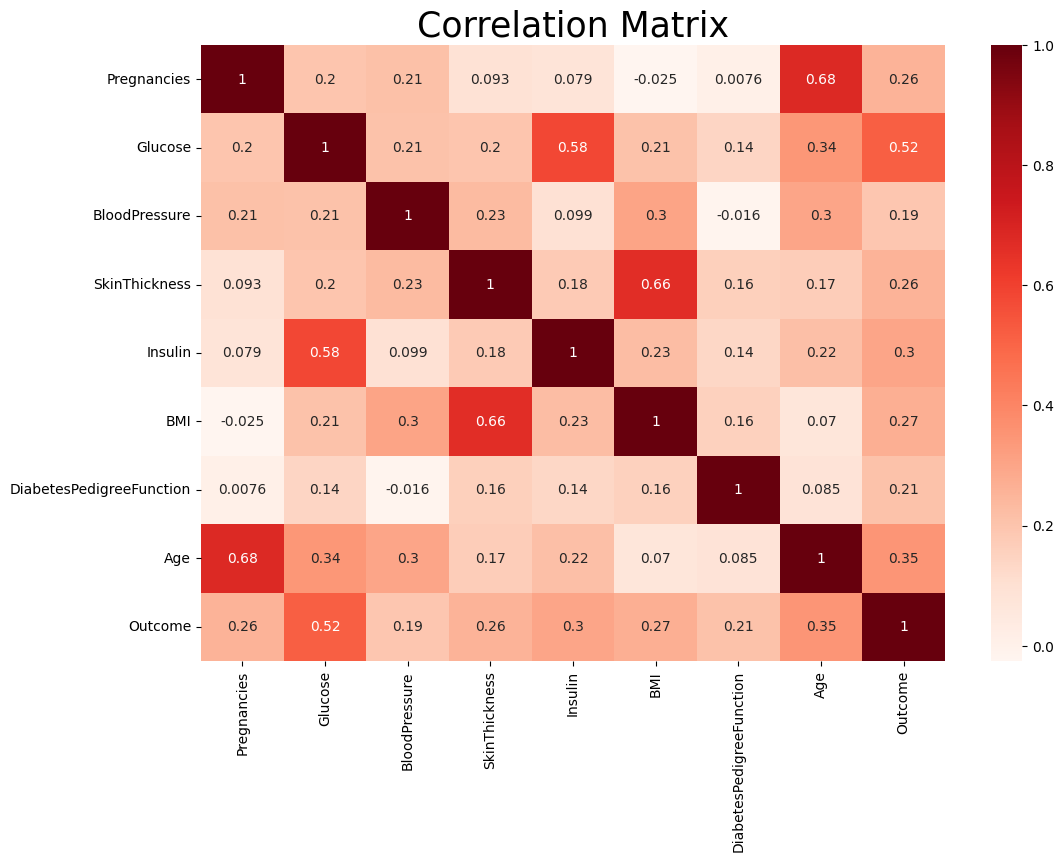

In [4]:
plt.figure(figsize = (12,8))
sns.heatmap(clean_data_df.corr(), annot = True, cmap = "Reds")
plt.title("Correlation Matrix", fontsize = 25);

In [5]:
X_df = clean_data_df.drop(['Outcome'], axis=1)
Y_df = clean_data_df['Outcome']

# define the model
model = XGBClassifier()
# fit the model
model.fit(X_df, Y_df)
# get importance
feature_importance = model.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


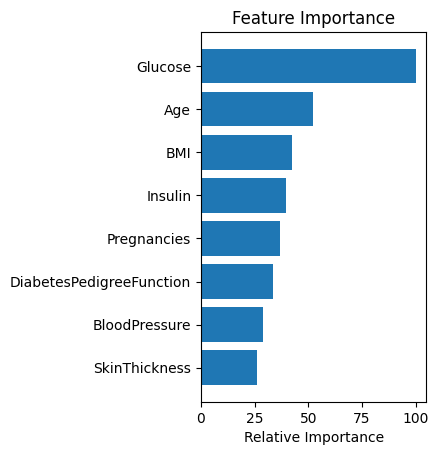

In [6]:
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, clean_data_df.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

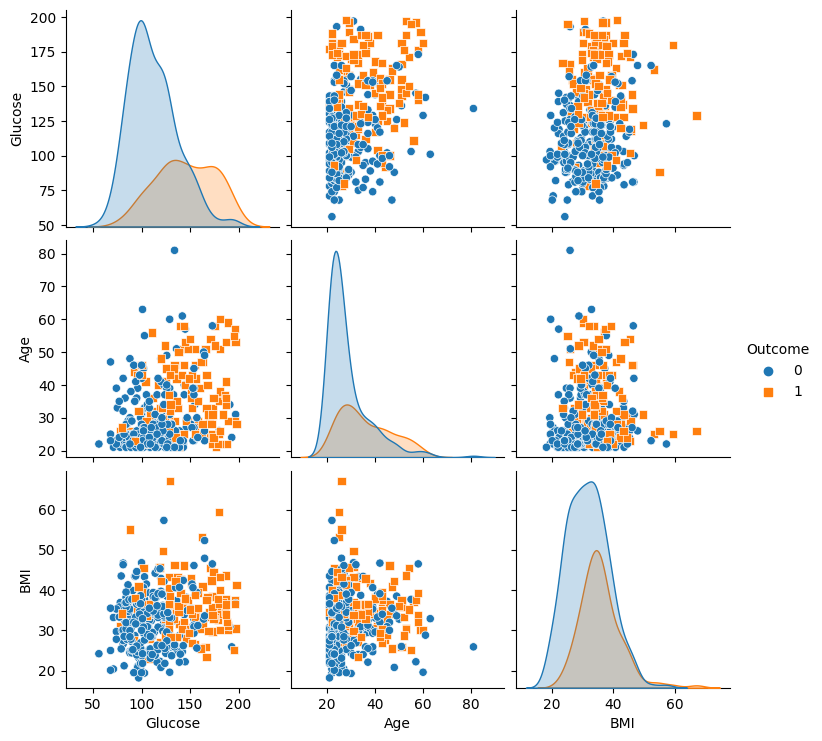

In [7]:
filter_clean_data_df = clean_data_df[['Glucose', 'Age', 'BMI', 'Outcome']]
sns.pairplot(filter_clean_data_df, hue="Outcome", markers=["o", "s"], corner=False)

In [8]:
glucose_boundaries = [53, 70, 97.5, 125, 162.5, 200]
bmi_boundaries = [18, 18.5, 25, 30, 35, 40, 68]
age_boundaries = [18, 22, 43, 51, 82]

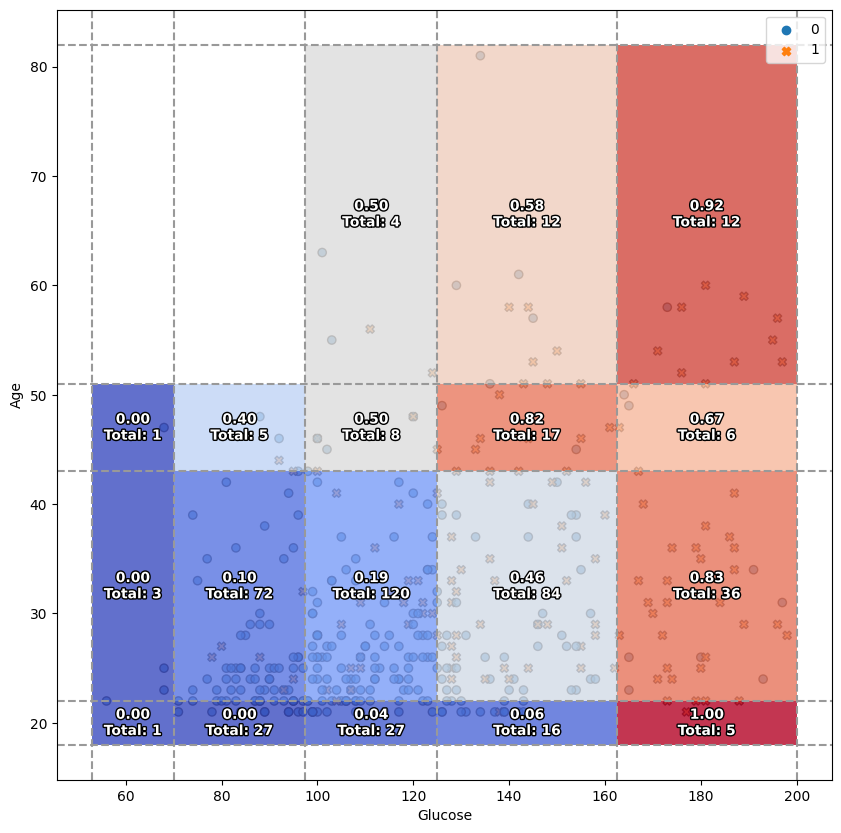

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_area_matrix(
    clean_data_df=clean_data_df,
    x_feature='Glucose',
    y_feature='Age',
    count_feature='Outcome',
    x_boundaries=glucose_boundaries,
    y_boundaries=age_boundaries,
    ax=ax
)

plt.legend(loc='upper right')
plt.show()

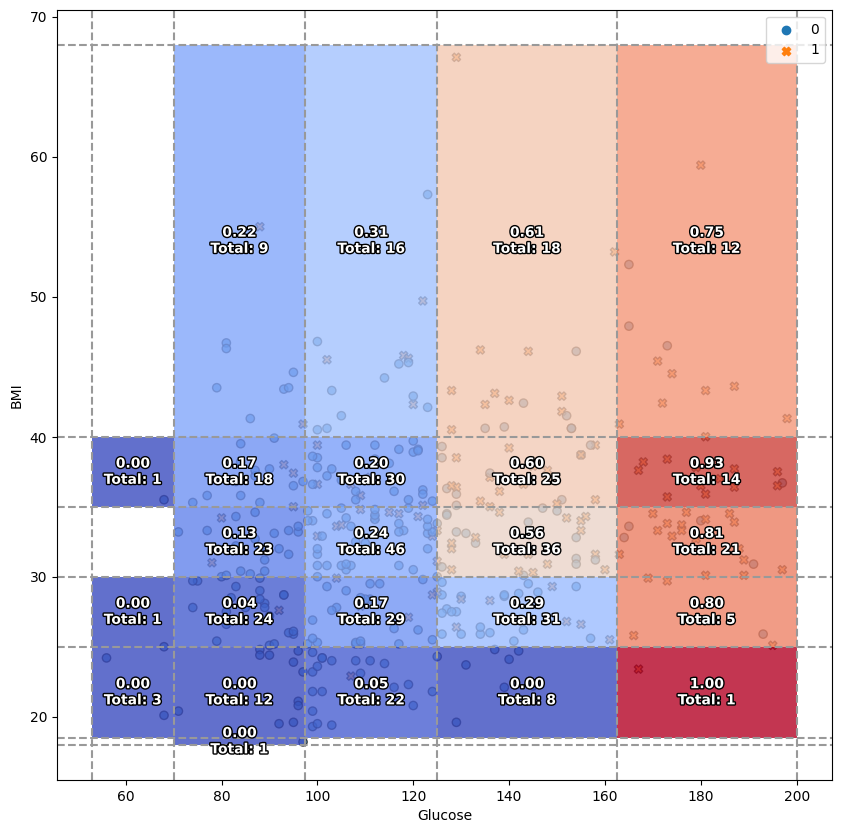

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_area_matrix(
    clean_data_df=clean_data_df,
    x_feature='Glucose',
    y_feature='BMI',
    count_feature='Outcome',
    x_boundaries=glucose_boundaries,
    y_boundaries=bmi_boundaries,
    ax=ax
)

plt.legend(loc='upper right')
plt.show()